#### packages & data

In [1]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

no display found. Using non-interactive Agg backend


In [2]:
DATA = '.'
LOAN200_CSV = DATA + 'loan200.csv'
LOAN3000_CSV = DATA + 'loan3000.csv'
LOAN_DATA_CSV = DATA + 'loan_data.csv.gz'

### 6.1 KNN

In [3]:
loan200 = pd.read_csv(LOAN200_CSV)
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

In [4]:
newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

In [5]:
newloan.values[0]

array([ 9. , 22.5])

In [6]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)

array(['paid off'], dtype=object)

#### knn 시각화

In [11]:
knn.kneighbors(newloan)

(array([[0.43787986, 0.88189485, 0.91751052, 1.65569826, 1.70611292,
         1.90596261, 2.08135622, 2.41682933, 2.44351029, 2.73230786,
         2.74245402, 2.86057968, 2.88767355, 2.99889915, 3.19912226,
         3.21420799, 3.36546794, 3.37976028, 3.462634  , 3.5414263 ]]),
 array([[ 34, 181, 180,  84,   8, 168,  20, 198,  76,  54, 140,  30,  65,
         162, 160, 111,  77,  45,  40, 138]]))

In [13]:
knn.kneighbors(newloan)[0].shape, knn.kneighbors(newloan)[1].shape

((1, 20), (1, 20))

In [17]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

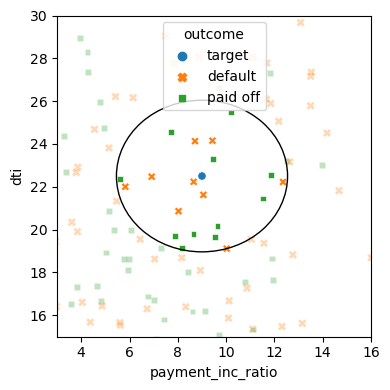

In [18]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), # X에서의 index를 loan200에서의 index로 변환 
                ax=ax, legend=False)

# 원그리기 
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)

ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

#### 정규화

In [8]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

KNeighborsClassifier()

In [11]:
nbrs = knn.kneighbors(newloan) # train data 기준 newloan에 대한 inference -> 가장 가까운 5개 점에 대한 거리, index 
X.iloc[nbrs[1][0], :] 

,payment_inc_ratio,dti,revol_bal,revol_util
35536,1.47212,1.46,1686,10.0
33651,3.38178,6.37,1688,8.4
25863,2.36303,1.39,1691,3.5
42953,1.28160,7.14,1684,3.9
43599,4.12244,8.98,1684,7.2


In [15]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors] # row index slicing, column name indexing
y = loan_data.loc[1:, outcome]

In [16]:
scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0) 

StandardScaler()

In [17]:
X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

In [20]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

KNeighborsClassifier()

In [21]:
nbrs = knn.kneighbors(newloan_std)

In [22]:
X.iloc[nbrs[1][0], :]

,payment_inc_ratio,dti,revol_bal,revol_util
2080,2.61091,1.03,1218,9.7
1438,2.34343,0.51,278,9.9
30215,2.71200,1.34,1075,8.5
28542,2.39760,0.74,2917,7.4
44737,2.34309,1.37,488,7.2


#### KNN을 통한 피처 엔지니어링

In [23]:
predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

In [24]:
X = loan_data[predictors]
y = loan_data[outcome]

In [25]:
knn = KNeighborsClassifier(n_neighbors=20)

In [26]:
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=20)

In [29]:
knn.predict_proba(X).shape # 하나의 레코드에 대해 클래스마다 속할 확률이 다 나옴 

(45342, 2)

In [27]:
# KNN으로 구한 default 예상 확률을 새로운 피처로 사용 가능 
loan_data['borrow_score'] = knn.predict_proba(X)[:, 1]
loan_data['borrow_score'].describe()

count    45342.000000
mean         0.498901
std          0.128735
min          0.050000
25%          0.400000
50%          0.500000
75%          0.600000
max          1.000000
Name: borrow_score, dtype: float64

### 6.2 Tree Model

In [6]:
# from sklearn.tree import DecisionTreeClassifier
loan3000 = pd.read_csv(LOAN3000_CSV)
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

In [8]:
loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', min_impurity_decrease=0.003)
loan_tree.fit(X, y)


DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.003,
                       random_state=1)

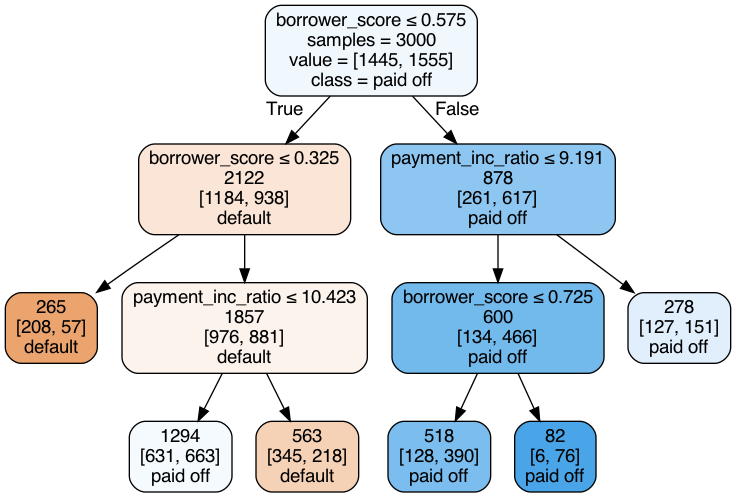

In [10]:
# from dmba import plotDecisionTree, textDecisionTree
## dmba: Data Mining for Business Analytics
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

In [11]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


### 6.3 Bagging & Random Forest

#### 랜덤 포레스트

In [6]:
# from sklearn.ensemble import RandomForestClassifier
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

In [7]:
X = loan3000[predictors]
y = loan3000[outcome]

In [8]:
rf = RandomForestClassifier(n_estimators=500, random_state=1, oob_score=True)

In [9]:
rf.fit(X, y)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1)

In [11]:
# oob_score_values
n_estimator = list(range(20, 510, 5))
oobScores = []

for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, criterion='entropy', max_depth=5, random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

<AxesSubplot: xlabel='n'>

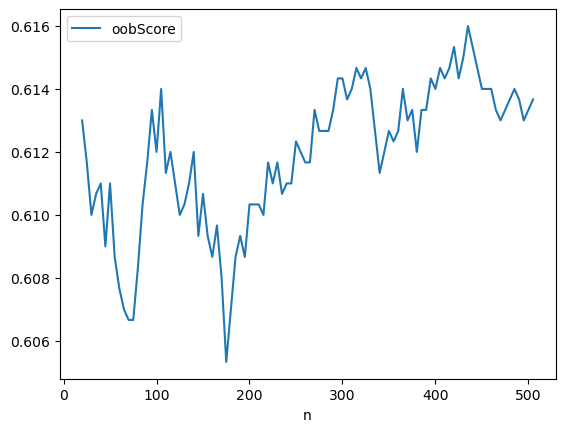

In [12]:
df = pd.DataFrame({ 'n': n_estimator, 'oobScore': oobScores}) # oob 점수는 높을 수록 좋다 
df.plot(x='n', y='oobScore')

In [13]:
# 예측 결과 시각화
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

,borrower_score,payment_inc_ratio,prediction
0,0.40,5.11135,default
1,0.40,5.43165,default
2,0.70,9.23003,paid off
3,0.40,2.33482,paid off
4,0.45,12.10320,default


Text(0, 0.5, 'payment_inc_ratio')

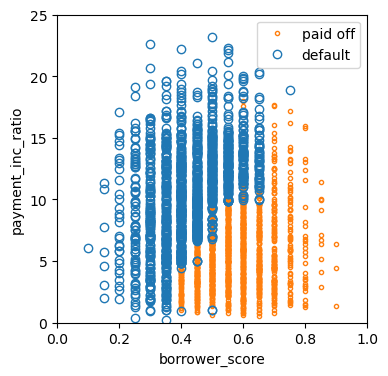

In [15]:
fig, ax = plt.subplots(figsize= (4, 4))
predictions.loc[predictions.prediction == 'paid off'].plot(x='borrower_score', y='payment_inc_ratio', style='.',
                                                           markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction == 'default'].plot(x='borrower_score', y='payment_inc_ratio', style='o',
                                                          markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default'])
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')
                    

#### 변수 중요도

In [43]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data.columns

Index(['Unnamed: 0', 'status', 'loan_amnt', 'term', 'annual_inc', 'dti',
       'payment_inc_ratio', 'revol_bal', 'revol_util', 'purpose',
       'home_ownership', 'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc',
       'grade', 'outcome', 'emp_length', 'purpose_', 'home_', 'emp_len_',
       'borrower_score'],
      dtype='object')

In [44]:
# 'Unnamed: 0', 'status', outcome, homeownership 칼럼 빼고 
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 'payment_inc_ratio', 
              'revol_bal', 'revol_util', 'purpose', 'delinq_2yrs_zero', 
              'pub_rec_zero', 'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
predictors

['loan_amnt',
 'term',
 'annual_inc',
 'dti',
 'payment_inc_ratio',
 'revol_bal',
 'revol_util',
 'purpose',
 'delinq_2yrs_zero',
 'pub_rec_zero',
 'open_acc',
 'grade',
 'emp_length',
 'purpose_',
 'home_',
 'emp_len_',
 'borrower_score']

In [45]:
len(predictors)

17

In [46]:
outcome = 'outcome'

In [47]:
test_df = loan_data[predictors]
test_df.dtypes

loan_amnt              int64
term                  object
annual_inc             int64
dti                  float64
payment_inc_ratio    float64
revol_bal              int64
revol_util           float64
purpose               object
delinq_2yrs_zero       int64
pub_rec_zero           int64
open_acc               int64
grade                float64
emp_length             int64
purpose_              object
home_                 object
emp_len_              object
borrower_score       float64
dtype: object

In [48]:
categorical_columns = test_df.select_dtypes(include=['object', 'category']).columns
categorical_columns 

Index(['term', 'purpose', 'purpose_', 'home_', 'emp_len_'], dtype='object')

In [49]:
factor_levels = {col: test_df[col].nunique() for col in categorical_columns}
factor_levels

{'term': 2, 'purpose': 12, 'purpose_': 7, 'home_': 3, 'emp_len_': 2}

In [50]:
sum(factor_levels.values()) - len(factor_levels)

21

In [51]:
# [predictors]: list of list
X = pd.get_dummies(loan_data[predictors], drop_first=True) # drop_first=True <- 다중공선성 방지 

In [52]:
X.shape

(45342, 33)

In [53]:
y = loan_data[outcome]

In [54]:
rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [55]:
# 지니 감소 기준으로 변수 정확도측정 
importances = rf_all.feature_importances_ 

In [56]:
# 정확도 감소는 별도의 코드로 계산
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)

In [58]:
# 다양한(3 set)의 데이터 랜덤 분할에 대해 scores 교차 검증 
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3)
    rf.fit(train_X, train_y) # train
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X)) # validate
    for column in X.columns: 
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values) # 특정 칼럼 값을 랜덤으로 재배치 
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc) / acc)

In [59]:
scores

defaultdict(list,
            {'loan_amnt': [-0.00033374123929249985,
              0.0006648199445984002,
              -0.0028707077398697606],
             'annual_inc': [0.00812103682278338,
              0.01650969529085871,
              0.012034890140223048],
             'dti': [0.000556235398820777,
              0.004432132963988889,
              0.004085237937506839],
             'payment_inc_ratio': [0.007008566025141824,
              0.012299168975069233,
              0.01302859666556249],
             'revol_bal': [0.0, 0.0026592797783934335, 0.00044164734459527087],
             'revol_util': [-0.0016687061964623313,
              0.0046537396121883,
              0.0007728828530418073],
             'delinq_2yrs_zero': [0.0006674824785848317,
              0.0009972299168976002,
              -0.000662471016893073],
             'pub_rec_zero': [0.000889976638113277,
              -0.00022160664819941095,
              0.00022082367229763543],
             'open_acc

In [62]:
df = pd.DataFrame({
    'feature': X.columns,
    'Accuracy decrease': [np.mean(scores[column]) for column in X.columns],
    'Gini decrease': rf_all.feature_importances_,})

In [63]:
df.head()

,feature,Accuracy decrease,Gini decrease
0,loan_amnt,-0.000847,0.080134
1,annual_inc,0.012222,0.093311
2,dti,0.003025,0.099014
3,payment_inc_ratio,0.010779,0.105864
4,revol_bal,0.001034,0.094270


In [64]:
df = df.sort_values('Accuracy decrease')

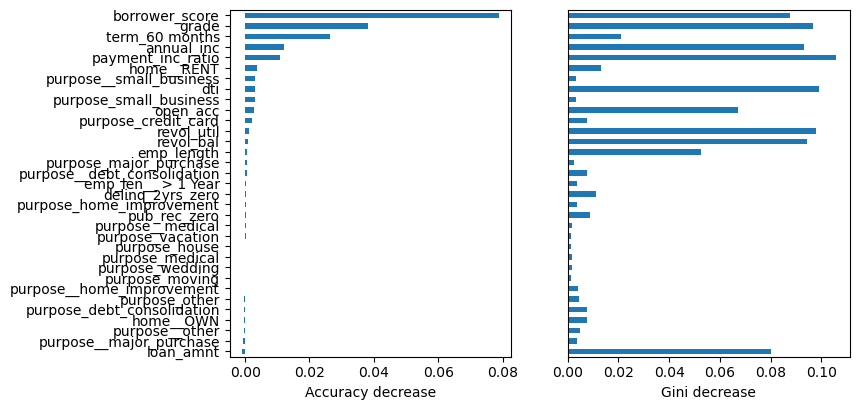

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4.5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', legend=False, ax=axes[0])
ax.set_ylabel('')
ax.set_xlabel('Accuracy decrease')
ax = df.plot(kind='barh', x='feature', y='Gini decrease', legend=False, ax=axes[1])
ax.set_ylabel('')
ax.set_xlabel('Gini decrease')
ax.get_yaxis().set_visible(False)